<a href="https://colab.research.google.com/github/gaheehan/NLP/blob/main/%ED%95%9C%EA%B5%AD%EC%96%B4_Word2Vec_%EB%A7%8C%EB%93%A4%EA%B8%B0(%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [27]:
# bash 셸로 명령어 입력하여 라이브러리 설치하기

%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Rea

In [28]:
# JAVA_HOME 환경변수 설정하기

%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [29]:
# okt 사용해보기 from konlpy

from konlpy.tag import Okt
okt=Okt()

# 형태소
print("okt.morphs : ", okt.morphs('안녕하세요. 저는 딥러닝 입니다.'))

# 명사
print("okt.nouns : ", okt.nouns('안녕하세요. 저는 딥러닝 입니다.'))

# 형태소 + 품사
print("okt.pos : ", okt.pos('안녕하세요. 저는 딥러닝 입니다.'))

okt.morphs :  ['안녕하세요', '.', '저', '는', '딥', '러닝', '입니다', '.']
okt.nouns :  ['저', '딥', '러닝']
okt.pos :  [('안녕하세요', 'Adjective'), ('.', 'Punctuation'), ('저', 'Noun'), ('는', 'Josa'), ('딥', 'Noun'), ('러닝', 'Noun'), ('입니다', 'Adjective'), ('.', 'Punctuation')]


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

네이버 영화 리뷰 데이터를 다운로드한다.

In [31]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f2ac720e710>)

네이버 영화 리뷰 데이터를 데이터프레임으로 로드하고 상위 5개의 행을 출력

In [32]:
train_data = pd.read_table('ratings.txt')

In [33]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [34]:
print(len(train_data)) # 리뷰 개수 출력

200000


총 20만개의 샘플이 존재하는데, 결측값 유무를 확인

In [35]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


결측값이 존재하므로 결측값이 존재하는 행을 제거

In [36]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


결측값이 삭제된 후의 리뷰 개수를 확인

In [37]:
print(len(train_data)) # 리뷰 개수 출력

199992


총 199,992개의 리뷰가 존재한다. 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행한다.

In [38]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [39]:
train_data.head() # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거할 것.  형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행. 

In [14]:
from tqdm import tqdm

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [10:08<00:00, 328.59it/s]


토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


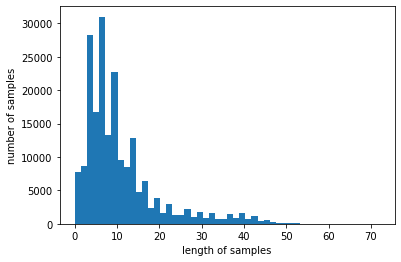

In [15]:
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습

In [16]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

학습이 다 되었다면 Word2Vec 임베딩 행렬의 크기를 확인



In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

총 16,477개의 단어가 존재하며 각 단어는 100차원으로 구성. '최민식'과 유사한 단어들을 뽑아보자

In [18]:
print(model.wv.most_similar("최민식"))

[('송강호', 0.8511807322502136), ('한석규', 0.8495119214057922), ('김명민', 0.8455930352210999), ('안성기', 0.8389647603034973), ('이주승', 0.8385835886001587), ('이정재', 0.8337137699127197), ('최민수', 0.8305460214614868), ('박중훈', 0.8276985883712769), ('김창완', 0.8198601603507996), ('단역', 0.8189811110496521)]


'히어로'와 유사한 단어들을 뽑아보자

In [19]:
print(model.wv.most_similar("히어로"))

[('무협', 0.8862549066543579), ('느와르', 0.8838306665420532), ('슬래셔', 0.8782199621200562), ('호러', 0.862442672252655), ('정통', 0.8453724384307861), ('블록버스터', 0.8449394702911377), ('물', 0.8315528035163879), ('물의', 0.8254095315933228), ('멜로', 0.8164454102516174), ('무비', 0.8162703514099121)]


'마블'과 유사한 단어들을 뽑아보자

In [20]:
print(model.wv.most_similar("마블"))

[('정치드라마', 0.8511802554130554), ('이블데드', 0.8363460302352905), ('마스터피스', 0.8308079242706299), ('극화', 0.8291631937026978), ('넘버원', 0.8289781808853149), ('데드', 0.8264243006706238), ('단언컨대', 0.8218196034431458), ('역사드라마', 0.8214364051818848), ('블레이드', 0.8184448480606079), ('시초', 0.8172984719276428)]


In [21]:
print(model.wv.most_similar("이종석"))

[('주지훈', 0.9025846719741821), ('신민아', 0.8992776870727539), ('이연희', 0.89825439453125), ('송승헌', 0.8945895433425903), ('이준', 0.8892533779144287), ('송새벽', 0.8880795836448669), ('최지우', 0.8857389092445374), ('서우', 0.883000373840332), ('김현주', 0.8825997114181519), ('주상욱', 0.8804725408554077)]


In [22]:
print(model.wv.most_similar("재밌다"))

[('재미있다', 0.9289184808731079), ('재다', 0.8948361873626709), ('실망하다', 0.5998063087463379), ('재미없다', 0.5890946388244629), ('웃기다', 0.5876098871231079), ('괜찮다', 0.5722007751464844), ('오래되다', 0.552733302116394), ('재밋', 0.5458372831344604), ('무섭다', 0.5400850772857666), ('꿀잼', 0.5371937155723572)]


In [23]:
print(model.wv.most_similar("노잼"))

[('노답', 0.7754691243171692), ('핵', 0.7686969637870789), ('꿀잼', 0.7177627086639404), ('깜놀', 0.7096251249313354), ('개핵', 0.6854501962661743), ('열자', 0.6853265166282654), ('개꿀잼', 0.6847109198570251), ('레알', 0.6484010219573975), ('급전', 0.6453310251235962), ('유치', 0.6445940732955933)]


In [ ]:
print(model.wv.most_similar("감동"))

In [25]:
print(model.wv.most_similar("팝콘"))

[('소문나다', 0.7666205167770386), ('햄버거', 0.7625941038131714), ('과자', 0.7523049116134644), ('도시락', 0.7500209808349609), ('콜라', 0.7414515018463135), ('맛있다', 0.7410151958465576), ('고기', 0.7390356063842773), ('흙', 0.731576681137085), ('칠하다', 0.7272019982337952), ('끓이다', 0.7271583080291748)]


In [26]:
print(model.wv.most_similar("인생"))

[('생애', 0.7478603720664978), ('평생', 0.7343608140945435), ('생', 0.7214868068695068), ('삶', 0.601943850517273), ('세운', 0.5780112743377686), ('곁', 0.5672043561935425), ('용면', 0.5648595094680786), ('속세', 0.5550926923751831), ('맘속', 0.5480811595916748), ('그동안', 0.5390211343765259)]
